In [14]:
import unittest, json, pandas as pd, os, numpy as np
from datetime import datetime
from compare_pandas import *
from compare_files import compare_files

Resources:<br>
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html<br>
http://pandas.pydata.org/pandas-docs/stable/api.html<br>
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.reindex.html<br>
http://pandas.pydata.org/pandas-docs/stable/merging.html

`get_data`: Use the data in `N_seaice_extent_daily_v3.0.csv` to create and return a `Series` object.  I suggest using `read_csv`, https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html.   You can do it in two steps: read in a `DataFrame`, then extract the `Series`.  The csv file looks like this in Excel: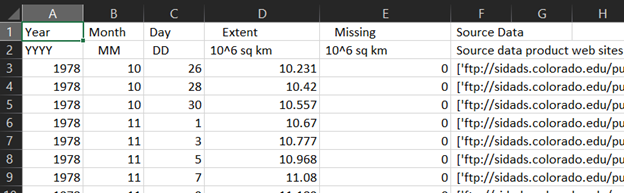

To get the frame, I suggest the syntax in the relevant Jupyter notebook.  There is more than one way to create the `Series` from the resulting frame.  The desired result is imaged below.  Notice that the file starts out with data for every other day and I have re-indexed my `Series` so that it has a position for every day (see the class materials for syntax to do this).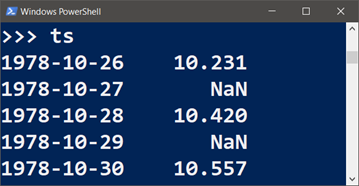

In [2]:
def get_data():
    # Since df is just an intermediate, I don't really need to make the 
    # nice column labels, but I gotta love it...
    fname = 'N_seaice_extent_daily_v3.0.csv'
    ts = pd.read_csv(fname, skiprows=2, usecols=[0, 1, 2, 3],  
                     parse_dates={'Dates': [0, 1, 2]}, 
                     header=None, squeeze=True, index_col='Dates')
    #ts.index.name = None # if you want to get rid of the index name
    # to do in one line, pass in datetime objects for the specific dates
    return ts.reindex(pd.date_range(ts.index[0], ts.index[-1]))

In [3]:
class TestFns(unittest.TestCase):
    def test_get_data(self):
        ts_correct = pd.read_pickle('raw_data.pkl')
        self.assertTrue(compare_series(ts_correct, get_data(), 
                                       0.001, dtype=True))
        
test = unittest.defaultTestLoader.loadTestsFromTestCase(TestFns)
results = unittest.TextTestRunner().run(test)

if len(results.errors) == len(results.failures) == 0:
    print('get_data passes!')
else:
    print('get_data does not pass.')

.

get_data passes!



----------------------------------------------------------------------
Ran 1 test in 1.391s

OK


<font color=red>***Used these to check that the updated assignment is still doing what it's supposed to. Also, use to check that the data hasn't been revised.***

In [4]:
ts = get_data()
ts.head()

1978-10-26    10.231
1978-10-27       NaN
1978-10-28    10.420
1978-10-29       NaN
1978-10-30    10.557
Freq: D, Name: 3, dtype: float64

In [5]:
ts.tail()

2020-08-27    4.363
2020-08-28    4.448
2020-08-29    4.365
2020-08-30    4.260
2020-08-31    4.200
Freq: D, Name: 3, dtype: float64

`clean_data`:  This function takes the `Series` created in `get_data` and alters it in place by filling in the missing data.  For slots that have data for the previous and following days, replace `NaN` with the mean of those two days.  For the extended period of missing data that begins in late 1987 and ends in early 1988, replace `NaN` with the mean of the previous year and the following year on the same day of the year (hint: 1988 was a leap year).  Use sequential for loops (not nested for loops) to accomplish this task – the first loop for the every-other-day missing data, the second for the consecutively missing data.  If you do everything inside one loop, when your code reaches the last day of the consecutively missing data, it will have filled in the previous day, fulfilling the every-other-day condition and your code will misfire.

In [6]:
def clean_data(ts):
    # first take care of the every other day issue in the earlier data
    # by filling in the missing data with the mean of the days before and after
    for i in range(len(ts)): 
        if pd.isnull(ts[i]): # should be doing ave +-5 years
            ts[i] = (ts[i - 1] + ts[i + 1]) / 2 # won't change anything if either is NaN
    # now deal with the end 1987-start 1988 gap by meaning the pre- and post- years
    for i in range(len(ts)): 
        if pd.isnull(ts[i]):
            '''
            previous_year = datetime(ts.index[i].year - 1, ts.index[i].month, ts.index[i].day)
            next_year = datetime(ts.index[i].year + 1, ts.index[i].month, ts.index[i].day)
            ts[i] = (ts[previous_year] + ts[next_year]) / 2
            ''' # should be doing ave +-5 years
            ts[i] = (ts[i - 365] + ts[i + 366]) / 2 # 366 because 1988 was a leap year

In [7]:
class TestFns(unittest.TestCase):
    def test_clean_data(self):
        ts_correct = pd.read_pickle('clean_data.pkl')
        raw = pd.read_pickle('raw_data.pkl')
        better_be_none = clean_data(raw)
        self.assertTrue(compare_series(ts_correct, raw, 0.001, dtype=True))
        self.assertIsNone(better_be_none)

test = unittest.defaultTestLoader.loadTestsFromTestCase(TestFns)
results = unittest.TextTestRunner().run(test)

if len(results.errors) == len(results.failures) == 0:
    print('clean_data passes!')
else:
    print('clean_data does not pass.')

.

clean_data passes!



----------------------------------------------------------------------
Ran 1 test in 0.735s

OK


In [8]:
clean_data(ts)
ts.head()

1978-10-26    10.2310
1978-10-27    10.3255
1978-10-28    10.4200
1978-10-29    10.4885
1978-10-30    10.5570
Freq: D, Name: 3, dtype: float64

In [9]:
ts.tail()

2020-08-27    4.363
2020-08-28    4.448
2020-08-29    4.365
2020-08-30    4.260
2020-08-31    4.200
Freq: D, Name: 3, dtype: float64

`get_column_labels`:  Generate and return a list of strings that will be used as column labels in a `DataFrame` that will look like: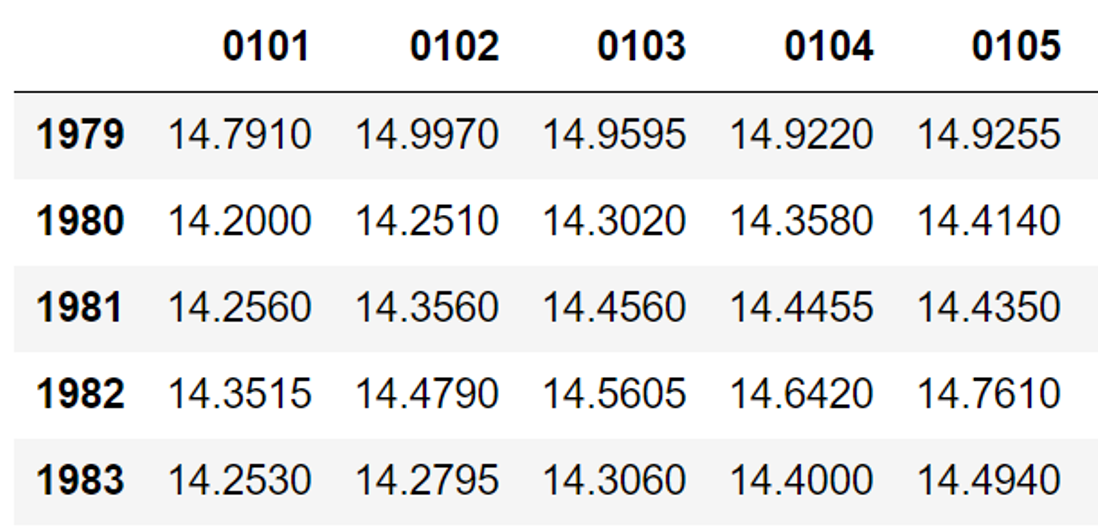<br>Every day of the non-leap year should be represented by an `mmdd` string.

In [10]:
def get_column_labels():
    return pd.date_range('2015-01-01', '2015-12-31').strftime('%m%d').tolist() 

In [11]:
class TestFns(unittest.TestCase):
    def test_get_column_labels(self):
        with open('columns.json') as fp:
            correct = json.load(fp) 
        self.assertEqual(correct, get_column_labels())

test = unittest.defaultTestLoader.loadTestsFromTestCase(TestFns)
results = unittest.TextTestRunner().run(test)

if len(results.errors) == len(results.failures) == 0:
    print('get_column_labels passes!')
else:
    print('get_column_labels does not pass.')

.

get_column_labels passes!



----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


`extract_df`:  This function takes the cleaned `Series` as its argument and creates and returns a new `DataFrame` (partially pictured above).  This `DataFrame` will have the years (ints) from 1979 to 2018 as row labels and the strings from `get_column_labels` as column labels.  Create an empty `DataFrame` with those labels.  Also pass in the argument `np.float64` by keyword `dtype`.  Then fill in the data using the appropriate values from the `Series` (hint: nested for loops).

In [12]:
def extract_df(ts):    
    df = pd.DataFrame(index=list(range(1979, 2020)), columns=get_column_labels(), 
                      dtype=np.float64)
    for year in df.index:
        for mmdd in df.columns:
            df.loc[year, mmdd] = ts[datetime(year, int(mmdd[:2]), int(mmdd[2:]))]
    return df

In [15]:
class TestFns(unittest.TestCase):
    def test_extract_df(self):
        ts_correct = pd.read_pickle('clean_data.pkl')
        df_correct = pd.read_pickle('data_79_19.pkl')
        self.assertTrue(compare_frames(df_correct, extract_df(ts_correct), 0.001))

test = unittest.defaultTestLoader.loadTestsFromTestCase(TestFns)
results = unittest.TextTestRunner().run(test)

if len(results.errors) == len(results.failures) == 0:
    print('extract_df passes!')
else:
    print('extract_df does not pass.')

.

extract_df passes!



----------------------------------------------------------------------
Ran 1 test in 2.121s

OK


In [16]:
df = extract_df(ts)
df.head()

0101     0102     0103     0104     0105     0106     0107    0108  \
1979  14.7910  14.9970  14.9595  14.9220  14.9255  14.9290  14.9485  14.968   
1980  14.2000  14.2510  14.3020  14.3580  14.4140  14.4660  14.5180  14.556   
1981  14.2560  14.3560  14.4560  14.4455  14.4350  14.5620  14.6890  14.654   
1982  14.3515  14.4790  14.5605  14.6420  14.7610  14.8800  14.9365  14.993   
1983  14.2530  14.2795  14.3060  14.4000  14.4940  14.4805  14.4670  14.541   

         0109     0110  ...     1222     1223     1224     1225     1226  \
1979  15.0790  15.1900  ...  13.6190  13.6960  13.7730  13.8535  13.9340   
1980  14.5940  14.6295  ...  13.7790  13.7885  13.7980  13.8990  14.0000   
1981  14.6190  14.6545  ...  13.8850  13.8770  13.9465  14.0160  13.9845   
1982  15.0225  15.0520  ...  13.9630  14.0280  14.0930  14.1380  14.1830   
1983  14.6150  14.6315  ...  13.4325  13.5390  13.5395  13.5400  13.6020   

         1227     1228     1229    1230     1231  
1979  14.0175  14.1010  14.0965  14.092  14.1460  
1980  14.0860  14.1720  14.1325  14.093  14.1745  
1981  13.9530  14.0405  14.1280  14.176  14.2240  
1982  14.1635  14.1440  14.1515  14.159  14.2060  
1983  13.6640  13.7595  13.8550  13.881  13.9070  

[5 rows x 365 columns]

In [17]:
df.tail()

0101    0102    0103    0104    0105    0106    0107    0108    0109  \
2015  13.073  13.125  13.112  13.051  13.115  13.138  13.180  13.231  13.292   
2016  12.721  12.806  12.790  12.829  12.874  13.039  13.079  13.101  13.186   
2017  12.643  12.644  12.713  12.954  12.956  12.839  12.881  12.870  12.847   
2018  12.484  12.600  12.634  12.724  12.834  12.772  12.750  12.740  12.874   
2019  12.934  12.992  12.980  13.045  13.147  13.316  13.282  13.236  13.458   

        0110  ...    1222    1223    1224    1225    1226    1227    1228  \
2015  13.254  ...  12.381  12.407  12.507  12.661  12.650  12.680  12.745   
2016  13.387  ...  11.831  11.737  11.865  12.027  12.088  12.291  12.484   
2017  12.896  ...  12.075  12.050  12.140  12.229  12.339  12.291  12.235   
2018  12.870  ...  12.269  12.316  12.253  12.273  12.272  12.325  12.344   
2019  13.383  ...  12.327  12.436  12.494  12.545  12.638  12.721  12.712   

        1229    1230    1231  
2015  12.762  12.800  12.735  
2016  12.525  12.617  12.553  
2017  12.223  12.273  12.397  
2018  12.523  12.569  12.621  
2019  12.780  12.858  12.889  

[5 rows x 365 columns]

`extract_2020`:  This function takes the cleaned `Series` as its argument and returns a `Series` containing the data for 2019.  This `Series` will have the same format as the cleaned `Series` – `datetime` objects as labels and sea ice extent floats for values.

In [18]:
def extract_2020(ts):
    return ts[datetime(2020, 1, 1):]

In [19]:
class TestFns(unittest.TestCase):
    def test_extract_2020(self):
        ts_clean_correct = pd.read_pickle('clean_data.pkl')
        ts_correct = pd.read_pickle('data_2020.pkl')
        ts = extract_2020(ts_clean_correct)
        self.assertTrue(compare_series(ts_correct, ts, 0.001, dtype=True))

test = unittest.defaultTestLoader.loadTestsFromTestCase(TestFns)
results = unittest.TextTestRunner().run(test)

if len(results.errors) == len(results.failures) == 0:
    print('extract_2020 passes!')
else:
    print('extract_2020 does not pass.')

.

extract_2020 passes!



----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


In [20]:
ts_2020 = extract_2020(ts)
ts_2020.head()

2020-01-01    13.102
2020-01-02    13.075
2020-01-03    13.176
2020-01-04    13.187
2020-01-05    13.123
Freq: D, Name: 3, dtype: float64

In [21]:
ts_2020.tail()

2020-08-27    4.363
2020-08-28    4.448
2020-08-29    4.365
2020-08-30    4.260
2020-08-31    4.200
Freq: D, Name: 3, dtype: float64

`main`:  Use the above functions to read in the data we want, clean it, and store it to disk in the files `data_79_19.csv` and `data_2020.csv` using the `to_csv` methods for frames and `Series`. When you call `to_csv` on the `Series` object, make sure you pass in this keyword argument: `header=False`.

In [22]:
def main():
    ts = get_data()
    clean_data(ts)
    df = extract_df(ts)
    df.to_csv('data_79_19.csv')
    ts_2020 = extract_2020(ts)
    ts_2020.to_csv('data_2020.csv', header=False)

In [23]:
class TestFns(unittest.TestCase):
    def test_main(self):
        if os.path.exists('data_79_19.csv'):
            os.remove('data_79_19.csv')
        if os.path.exists('data_2020.csv'):
            os.remove('data_2020.csv')
        main()
        # get rid of the apply F18 - the pkl is now float
        df_correct = pd.read_pickle('data_79_19.pkl').apply(pd.to_numeric)
        df = pd.read_csv('data_79_19.csv', index_col=0)
        self.assertTrue(compare_frames(df_correct, df, 0.001, dtype=True))
        ts_correct = pd.read_pickle('data_2020.pkl')
        # this actually creates a weird Series with index.name == 0.
        # could assign to None if I cared.
        ts = pd.read_csv('data_2020.csv', header=None, parse_dates=True, squeeze=True, index_col=0) 
        self.assertTrue(compare_series(ts_correct, ts, 0.001, dtype=True))

test = unittest.defaultTestLoader.loadTestsFromTestCase(TestFns)
results = unittest.TextTestRunner().run(test)

if len(results.errors) == len(results.failures) == 0:
    print('main passes!')
else:
    print('main does not pass.')

.

main passes!



----------------------------------------------------------------------
Ran 1 test in 4.170s

OK
